In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [2]:
!pip install split-folders


In [3]:
import splitfolders
data_dir = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_dir = '/kaggle/working/splitted_Data'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Copying files: 41793 files [08:08, 85.55 files/s] 


In [4]:
train_dir = "/kaggle/working/splitted_Data/train"
test_dir = "/kaggle/working/splitted_Data/test"
val_dir = "/kaggle/working/splitted_Data/val"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


Pixels of the first image after Normalization: 

[[[0.5921569  0.54509807 0.52156866]
  [0.5921569  0.54509807 0.52156866]
  [0.59607846 0.54901963 0.5254902 ]
  ...
  [0.43921572 0.3647059  0.41176474]
  [0.41960788 0.34901962 0.38431376]
  [0.3921569  0.30588236 0.34509805]]

 [[0.5882353  0.54509807 0.52156866]
  [0.5882353  0.54509807 0.52156866]
  [0.5921569  0.54509807 0.52156866]
  ...
  [0.48627454 0.4156863  0.46274513]
  [0.46274513 0.3921569  0.42352945]
  [0.3921569  0.30980393 0.34509805]]

 [[0.58431375 0.5411765  0.5176471 ]
  [0.58431375 0.5411765  0.5176471 ]
  [0.5921569  0.54509807 0.52156866]
  ...
  [0.52156866 0.45882356 0.49803925]
  [0.4784314  0.41176474 0.43137258]
  [0.4039216  0.32156864 0.34901962]]

 ...

 [[0.4901961  0.4039216  0.3529412 ]
  [0.50980395 0.427451   0.3803922 ]
  [0.4901961  0.42352945 0.37254903]
  ...
  [0.454902   0.3921569  0.3372549 ]
  [0.45098042 0.3803922  0.33333334]
  [0.44705886 0.38823533 0.33333334]]

 [[0.5176471  0.43921572 

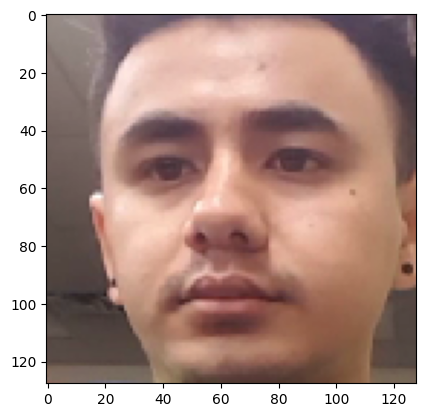

In [7]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[3]}")
plt.imshow(images[3])
plt.show()

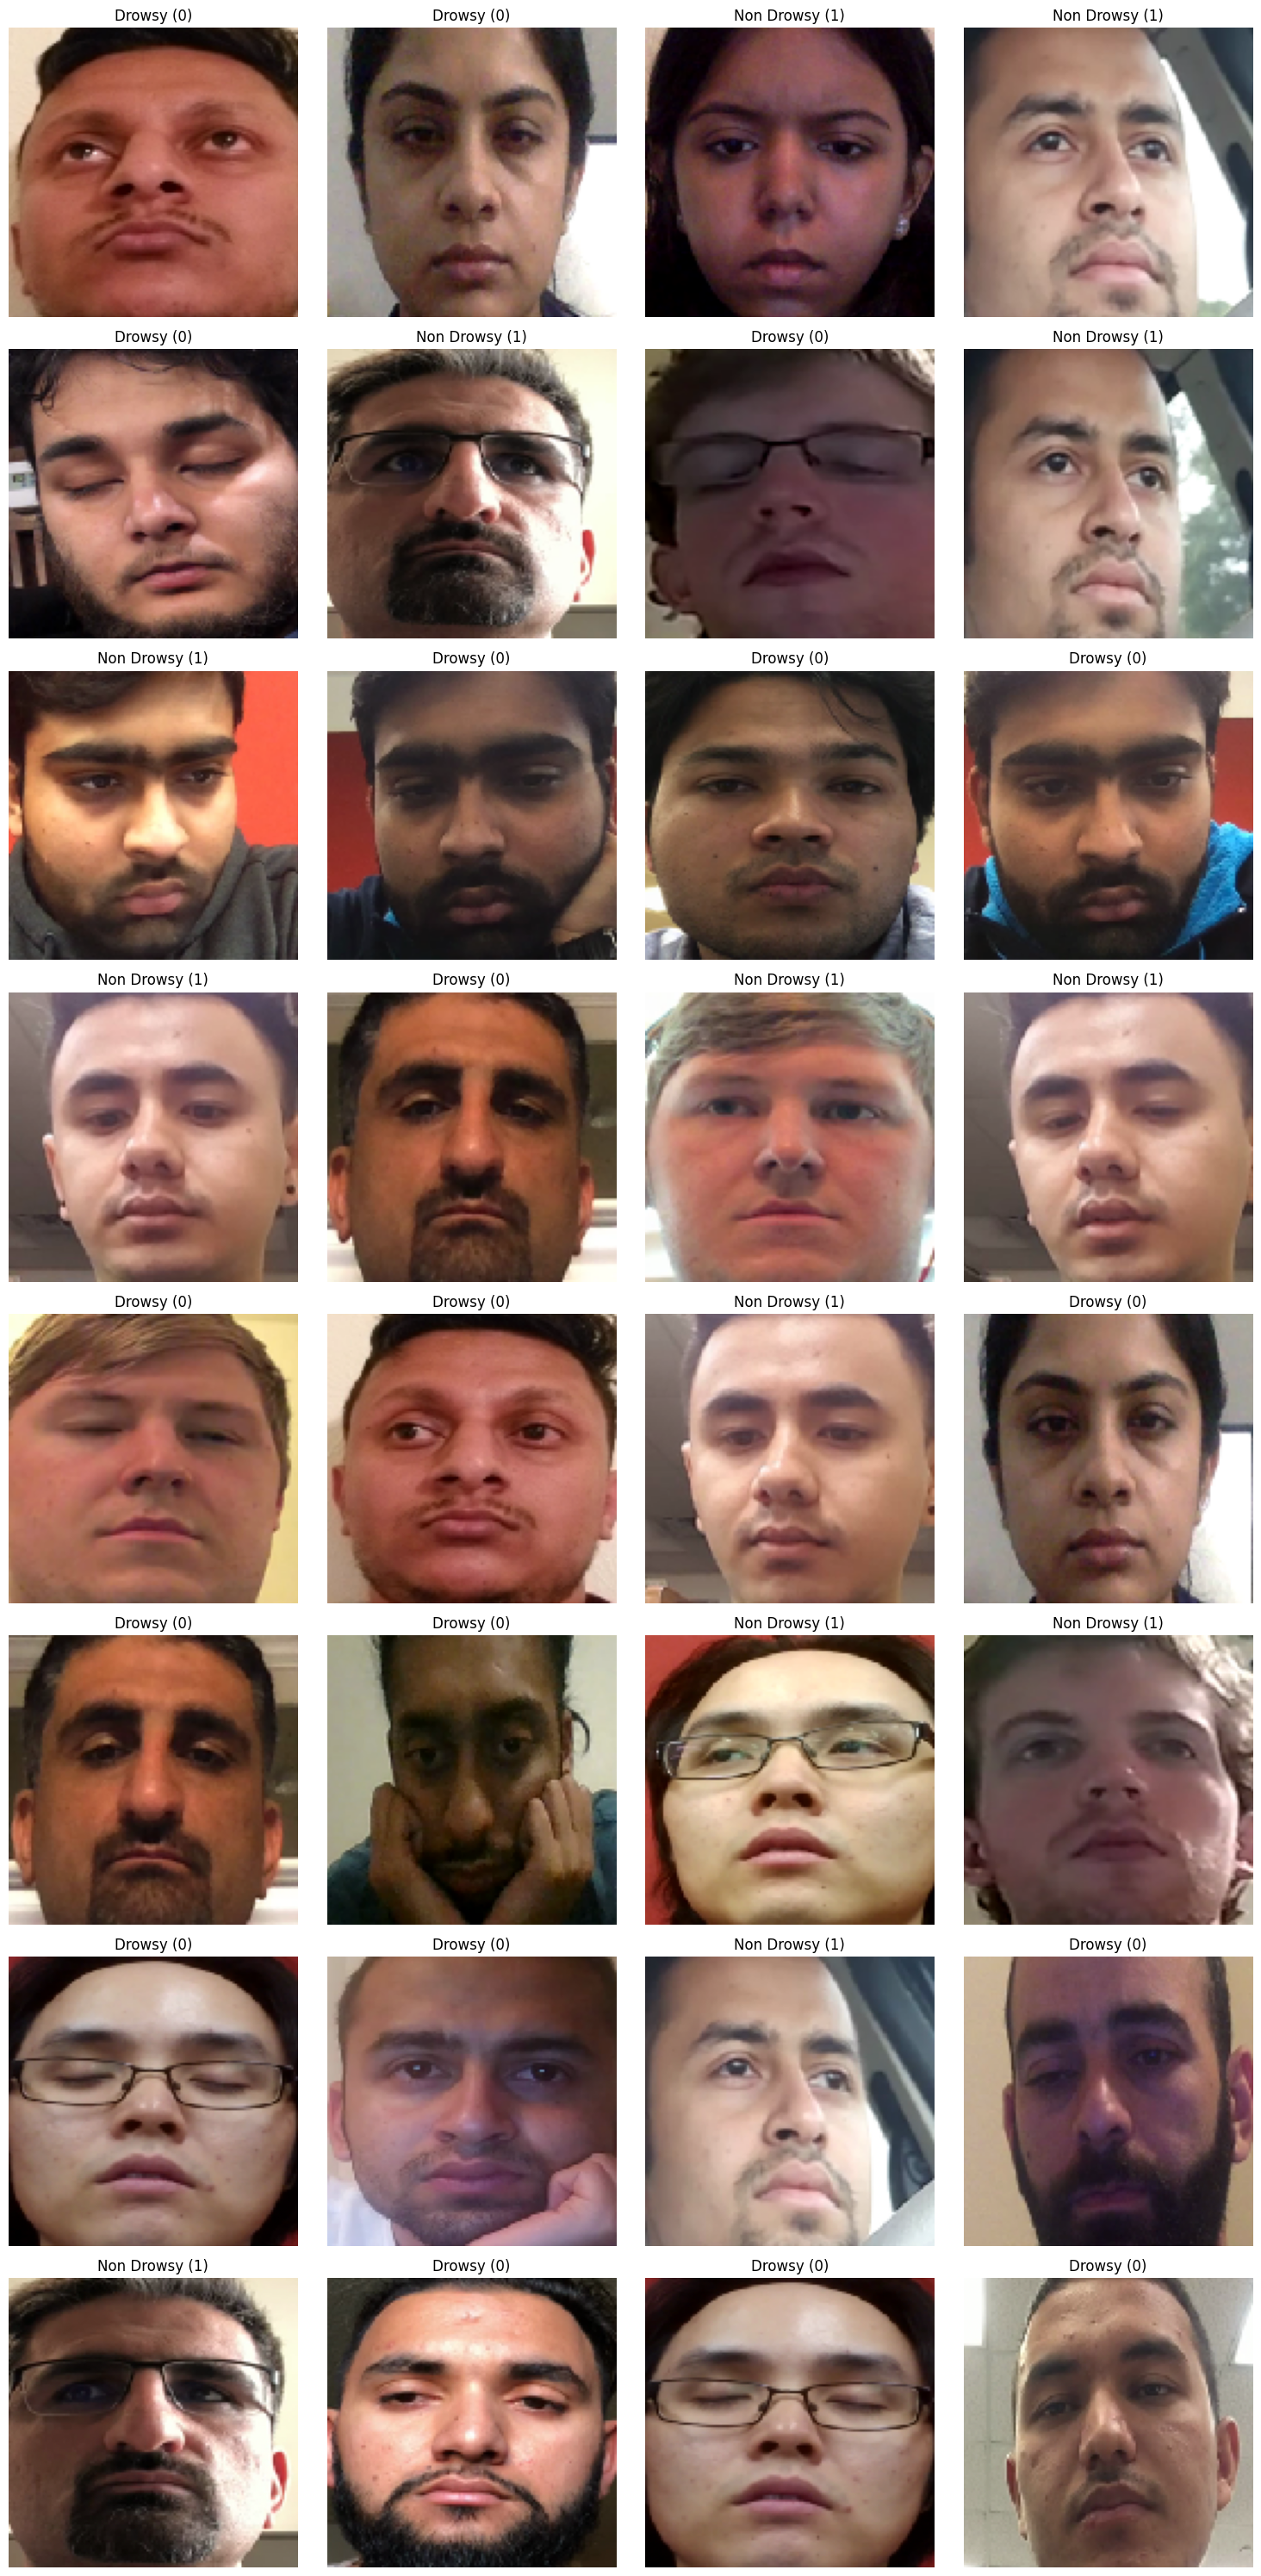

In [9]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):
        
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])  
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [10]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),  
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),  
    LSTM(16, return_sequences=False),  
    Dropout(0.3),

    Dense(8, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 5, 128, 128, 8)      │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 5, 128, 128, 8)      │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 5, 64, 64, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 5, 64, 64, 16)       │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 5, 64, 64, 16)       │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 5, 32, 32, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 5, 32, 32, 32)       │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 5, 32, 32, 32)       │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 5, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

In [13]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []
        
        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)
        
        return np.array(X_seq), np.array(y_seq)

In [14]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [15]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.4948 - loss: 0.7048 - val_accuracy: 0.4693 - val_loss: 0.7073
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.5573 - loss: 0.6807 - val_accuracy: 0.6126 - val_loss: 0.6676
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.5821 - loss: 0.6679 - val_accuracy: 0.6857 - val_loss: 0.6496
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.6019 - loss: 0.6575 - val_accuracy: 0.7159 - val_loss: 0.6344
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.6326 - loss: 0.6405 - val_accuracy: 0.7456 - val_loss: 0.6145
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.6496 - loss: 0.6246 - val_accuracy: 0.7644 - val_loss: 0.5931
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.6745 - loss: 0.6061 - val_accuracy: 0.7850 - val_loss: 0.5671
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.6940 - loss: 0.5856 - val_accuracy: 0.8249 - val_loss: 0.

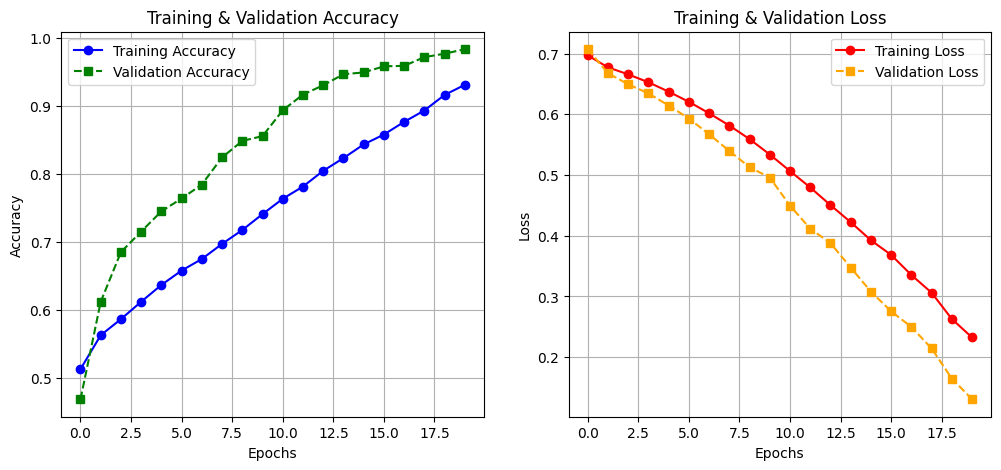

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", color="blue", marker="o", linestyle="-")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="green", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color="red", marker="o", linestyle="-")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True)

plt.show()